In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import Hawkes as hk
import datetime
import math
from math import ceil, sqrt
import os

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Load single day data and aggregate 1-Minute returns

In [22]:
data = pd.read_csv("./data/BTCTUSD-1s-2023-06-01.csv", header = None)[[0,4]]
data.columns = ["Time", "Close"]
data["Time"] = (data["Time"].apply(int)/1000).apply(datetime.datetime.utcfromtimestamp).values

print(data.shape)
data.head()

(86400, 2)


,Time,Close
0,2023-06-01 00:00:00,27224.68
1,2023-06-01 00:00:01,27223.59
2,2023-06-01 00:00:02,27224.82
3,2023-06-01 00:00:03,27225.19
4,2023-06-01 00:00:04,27224.32


In [23]:
df = data[::60]
ret = df.Close.pct_change()[1:].values
sigma = ret.std()
mu = ret.mean()

In [24]:
# threshold is 2 standard deviations above or below avg. return
n_sigma = 2

upper = mu + n_sigma*sigma
lower = mu - n_sigma*sigma

jumps = np.where((ret > upper).astype(int) + (ret < lower).astype(int))[0]
n_jumps = len(jumps)

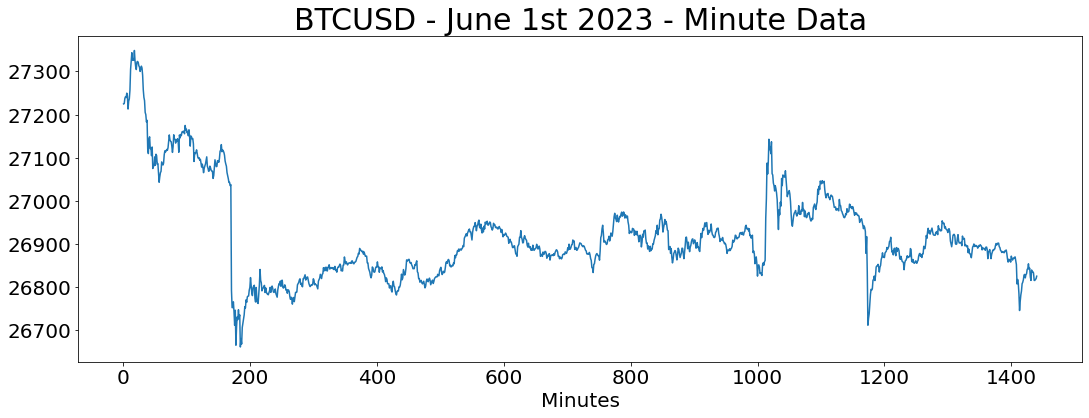

In [25]:
plt.rcParams["figure.figsize"] = (18,6)
plt.plot(np.arange(1, len(df.Close)+1), df.Close)

plt.title("BTCUSD - June 1st 2023 - Minute Data", fontsize = 30)
plt.xlabel("Minutes", fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

#plt.savefig("BTCUSD_1m_data.png", transparent = True)

plt.show()

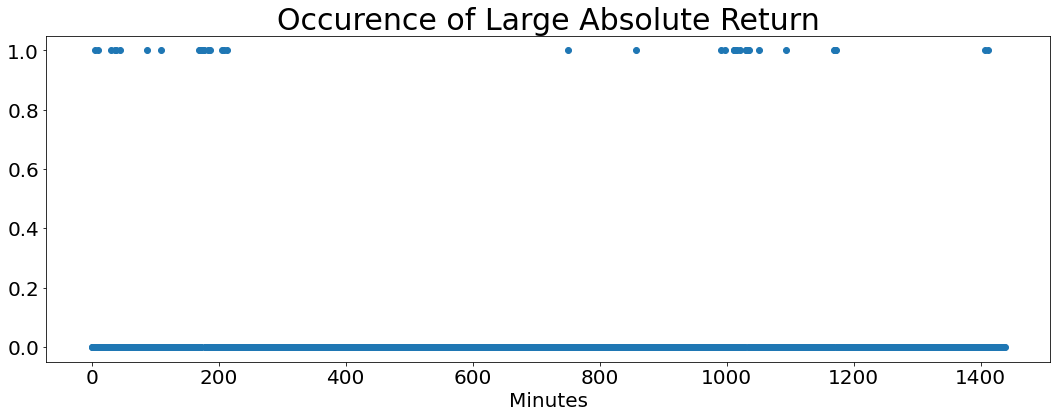

In [26]:
plt.rcParams["figure.figsize"] = (18,6)
plt.scatter(np.arange(len(ret)), (ret > upper).astype(int) + (ret < lower).astype(int))

plt.title("Occurence of Large Absolute Return", fontsize = 30)
plt.xlabel("Minutes", fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

#plt.savefig("BTCUSD_Jumps.png", transparent = True)

plt.show()

# Define jumps via Peak-over-Threshold

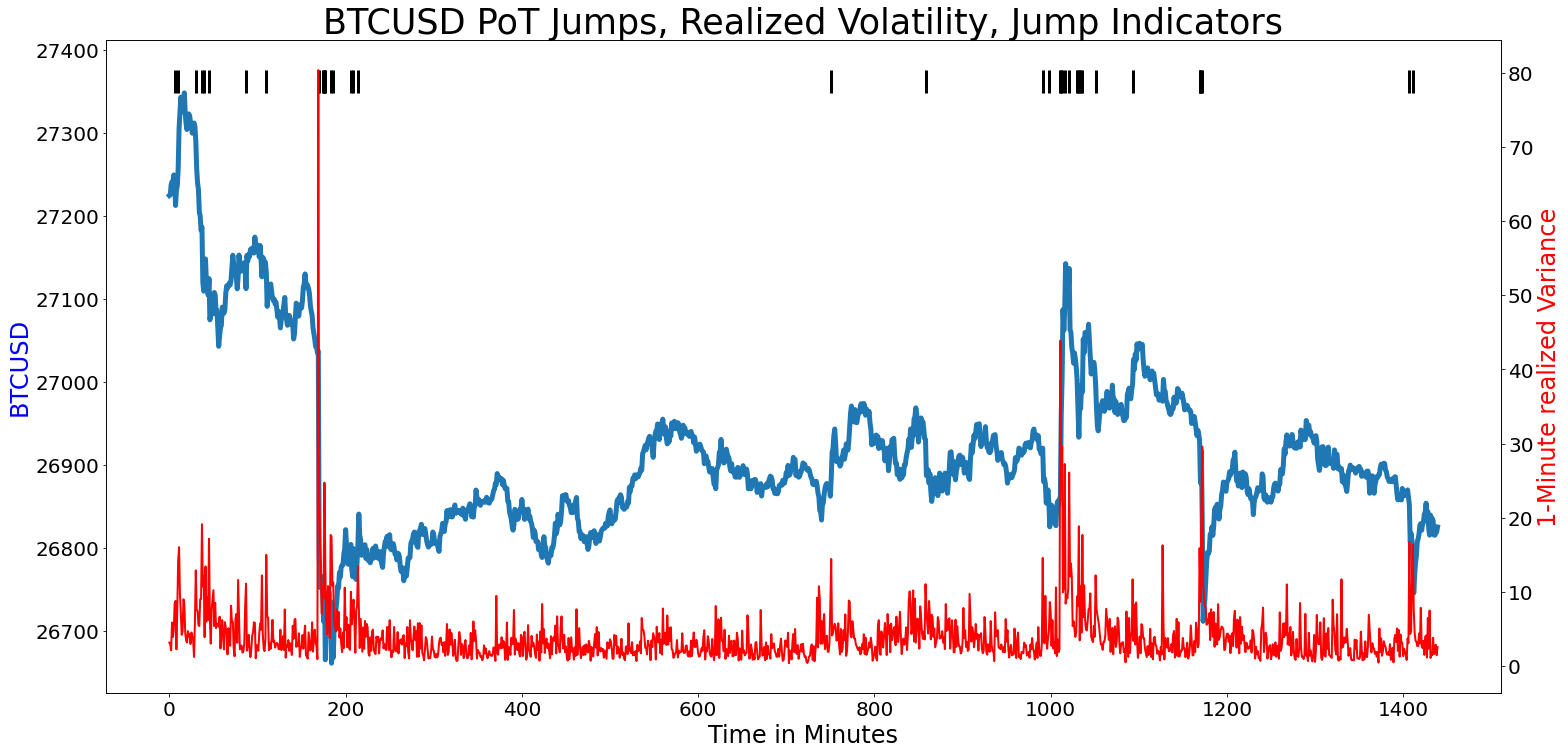

In [27]:
vola = data.reset_index().groupby(pd.Grouper(key='Time', freq='1min')).std().Close.values

plt.rcParams["figure.figsize"] = (25,12)

fig, ax = plt.subplots()


plt.title("BTCUSD PoT Jumps, Realized Volatility, Jump Indicators", fontsize = 35)


ax.plot(range(0, len(df.Time)), df.Close, linewidth=5)
for i in range(n_jumps):
    plt.vlines(jumps[i], ymin = max(df.Close), ymax = max(df.Close)*1.001, color = "black", linewidth = 3)
ax.set_xlabel("Time in Minutes",
              fontsize = 24)
ax.xaxis.set_tick_params(labelsize=20)
ax.set_ylabel("BTCUSD",
              color="blue",
              fontsize=24)
ax.yaxis.set_tick_params(labelsize = 20)

ax2 = ax.twinx()
ax2.set_ylabel("1-Minute realized Variance",
               color="red",
               fontsize=24)
ax2.yaxis.set_tick_params(labelsize = 20)
ax2.plot(range(0, len(vola)), vola, color = "red", linewidth = 2)

#plt.savefig("BTC Jumps and Realized Volaility.png", transparent=True)
plt.show()

# Estimate Hawkes Parameters

In [28]:
n_int = len(df.Close)

hawkes_est = hk.estimator()
hawkes_est.set_kernel("exp")
hawkes_est.set_baseline("const")

hawkes_est.fit(np.array(jumps).astype("float"), [0, n_int])

In [30]:
hawkes_est.parameter

{'mu': 0.009294010561077757,
 'alpha': 0.6739184185607762,
 'beta': 0.14866071968940087}

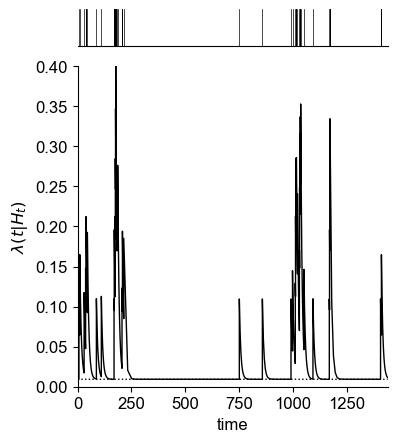

In [33]:
hawkes_est.plot_l()

# Estimate Stability of Parameters

In [37]:
baseline = []
alpha = []
beta = []

all_files = []
folder_path = './data'
for i, filename in enumerate(sorted(os.listdir(folder_path))[1:-1]):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        all_files.append(file_path)


for i, file_path in enumerate(all_files):
    data = pd.read_csv(file_path, header = None)[[0,4]]
    data.columns = ["Time", "Close"]
    data["Time"] = (data["Time"].apply(int)/1000).apply(datetime.datetime.utcfromtimestamp).values
    df = data[::60]
    ret = df.Close.pct_change()[1:].values
    sigma = ret.std()
    mu = ret.mean()
    upper = mu + n_sigma*sigma
    lower = mu - n_sigma*sigma

    jumps = np.where((ret > upper).astype(int) + (ret < lower).astype(int))[0]
    
    n_int = len(df.Close)
    
    hawkes_est = hk.estimator()
    hawkes_est.set_kernel("exp")
    hawkes_est.set_baseline("const")

    hawkes_est.fit(np.array(jumps).astype("float"), [0, n_int])
    baseline.append(hawkes_est.parameter["mu"])
    alpha.append(hawkes_est.parameter["alpha"])
    beta.append(hawkes_est.parameter["beta"])

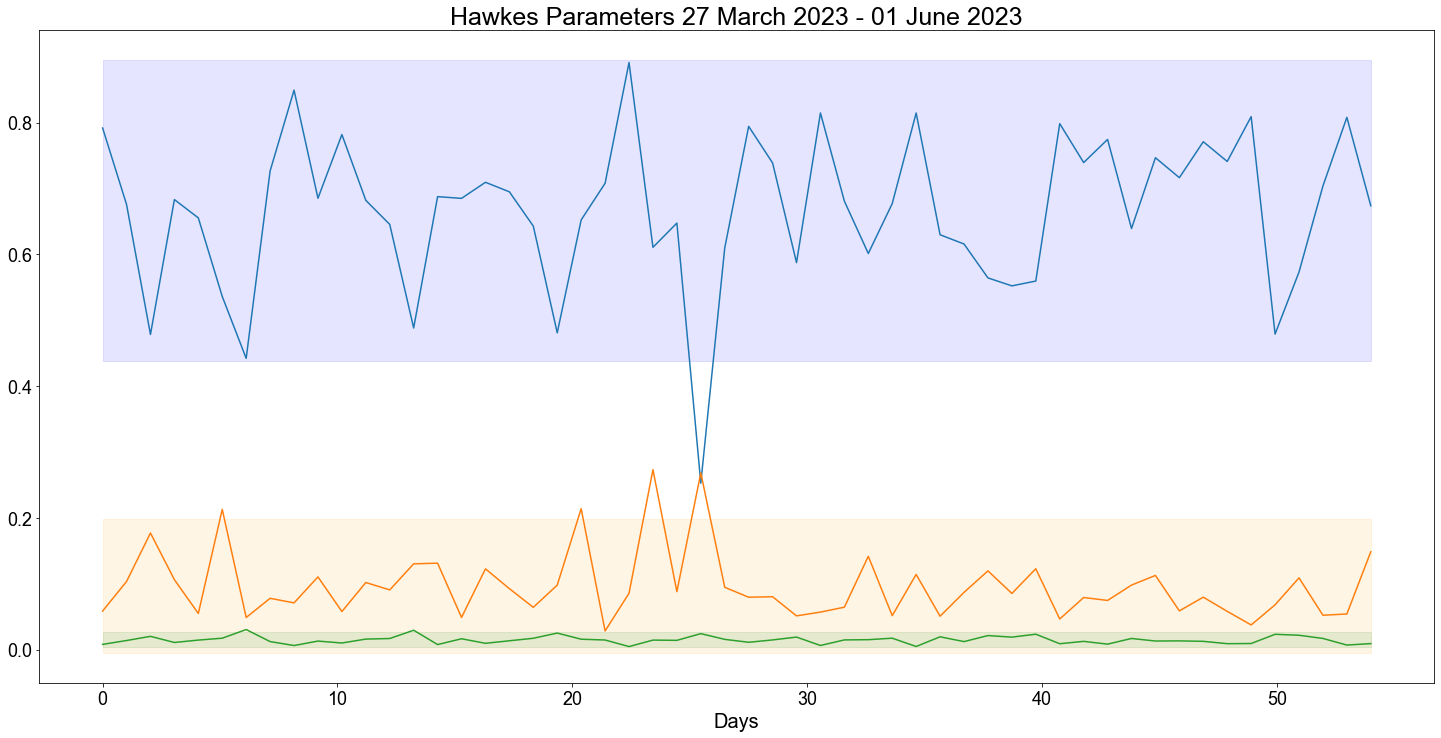

In [38]:
y1 = alpha.copy()
y2 = beta.copy()
y3 = baseline.copy()
x = np.linspace(0, len(alpha), len(alpha))


fig, ax = plt.subplots()
ax.plot(x,y1)
ax.fill_between(x, (np.mean(np.array(y1))-1.96*np.std(y1)), (np.mean(np.array(y1))+1.96*np.std(y1)), color='b', alpha=.1)
ax.plot(x,y2)
ax.fill_between(x, (np.mean(np.array(y2))-1.96*np.std(y2)), (np.mean(np.array(y2))+1.96*np.std(y2)), color='orange', alpha=.1)
ax.plot(x,y3)
ax.fill_between(x, (np.mean(np.array(y3))-1.96*np.std(y3)), (np.mean(np.array(y3))+1.96*np.std(y3)), color='green', alpha=.1)

plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.xlabel("Days", fontsize = 20)
plt.title("Hawkes Parameters 27 March 2023 - 01 June 2023", fontsize = 25)

#plt.savefig("Param_over_time.png", transparent = True)

plt.show()

# Simulate Hawkes Process

In [34]:
jump_sim = hk.simulator()
jump_sim.set_kernel("exp")
jump_sim.set_baseline("const")

jump_sim.set_parameter(hawkes_est.parameter)

In [35]:
n_sim_jump = []
n_sim = 1000

for _ in range(n_sim):
    n_sim_jump.append(len(jump_sim.simulate([0, 1440]).astype(int)))

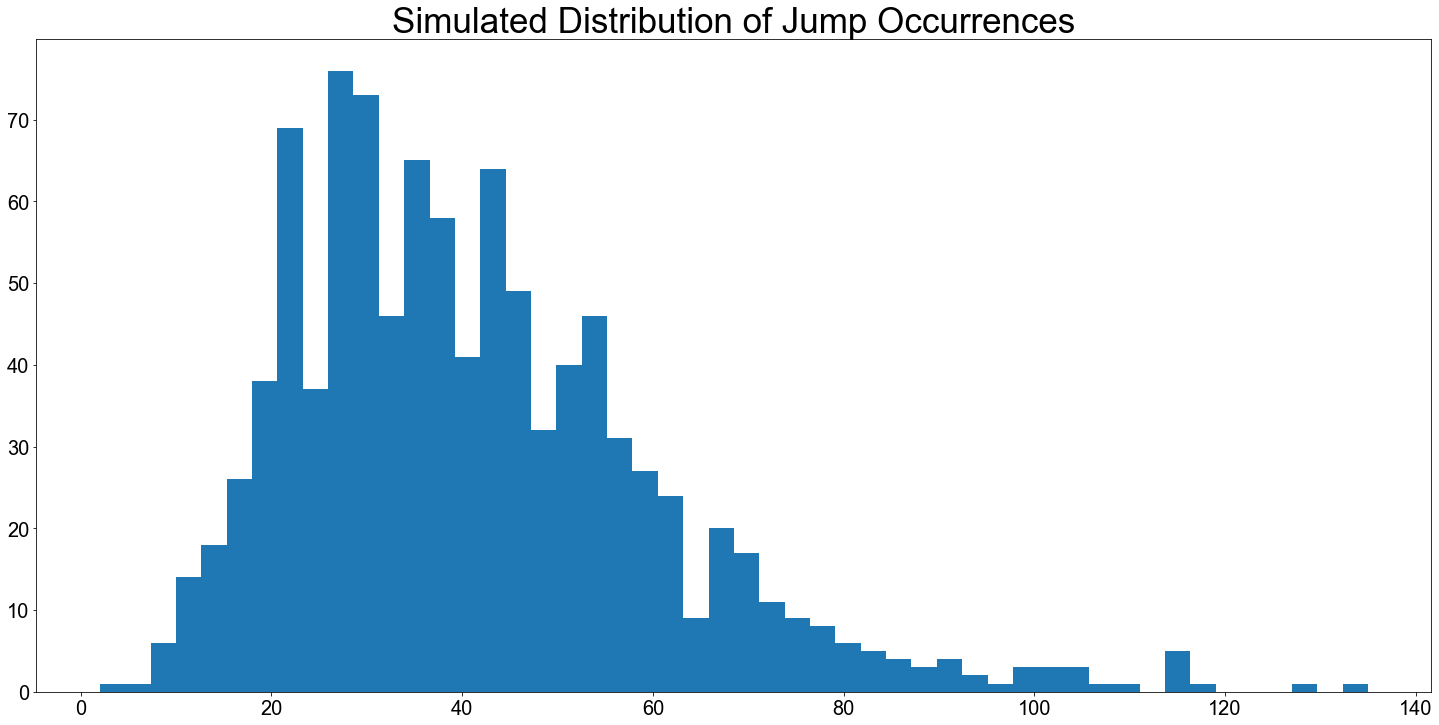

In [36]:
plt.hist(n_sim_jump, bins = 50)
plt.title("Simulated Distribution of Jump Occurrences", fontsize = 35)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)


#plt.savefig("Simulated Jumps.png", transparent = True)

plt.show()